# Demo

This is a small demo for the first 120s for camera 33,34 and 35

camera 33 and 34 has a block out region and 35 left as untourched

Frames sample rate set to 1fps

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

import cv2
import os

Load path for frames

In [2]:
path = Path('/home/heye0507/zhangyu_project')
data = Path(path/'data')

camera_33_files = Path(data/'frames/33')
camera_34_files = Path(data/'frames/34')
camera_35_files = Path(data/'frames/35') 

In [3]:
def get_files_in_dir(path,extensions=None):
    fs = [o.name for o in os.scandir(path) if o.is_file()]
    res = [path/f for f in fs if not f.startswith('.') and ((not extensions) or f'{f.split(".")[-1].lower()}' in extensions)]
    return res

In [4]:
camera_33_fpaths = get_files_in_dir(camera_33_files)
camera_34_fpaths = get_files_in_dir(camera_34_files)
camera_35_fpaths = get_files_in_dir(camera_35_files)

camera_33_fpaths = sorted(camera_33_fpaths,key=lambda i: os.path.splitext(os.path.basename(i))[0])
camera_34_fpaths = sorted(camera_34_fpaths,key=lambda i: os.path.splitext(os.path.basename(i))[0])
camera_35_fpaths = sorted(camera_35_fpaths,key=lambda i: os.path.splitext(os.path.basename(i))[0])

# Block out region demo

## For camera 33, regions to the right of the green line won't be count

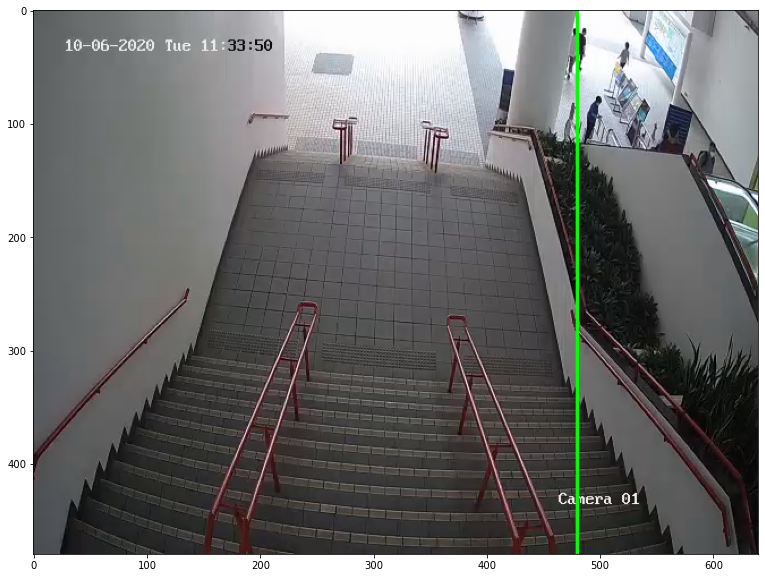

In [5]:
c33_img = cv2.imread(str(camera_33_fpaths[0]),cv2.IMREAD_COLOR)
c33_img = cv2.cvtColor(c33_img,cv2.COLOR_BGR2RGB).astype(np.float32)
_, ax = plt.subplots(1,1,figsize=(16,10))
c33_img /= 255.
c33_img = cv2.line(c33_img,(480,0),(480,480),(0,1,0),2)
ax.imshow(c33_img)

## For camera 34, regions of the top of the green line wont be count

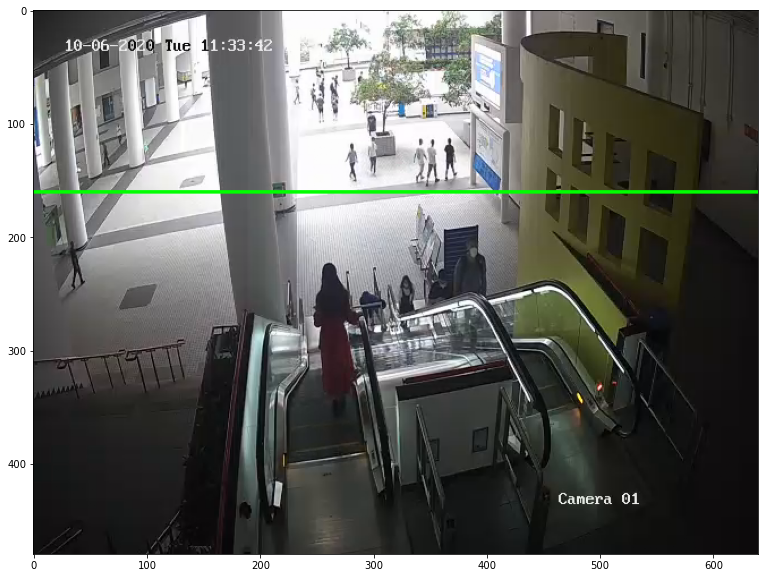

In [6]:
c34_img = cv2.imread(str(camera_34_fpaths[0]),cv2.IMREAD_COLOR)
c34_img = cv2.cvtColor(c34_img,cv2.COLOR_BGR2RGB).astype(np.float32)
_, ax = plt.subplots(1,1,figsize=(16,10))
c34_img /= 255.
c34_img = cv2.line(c34_img,(0,160),(640,160),(0,1,0),2)
ax.imshow(c34_img)

# Camera 35 doesn't have block out region

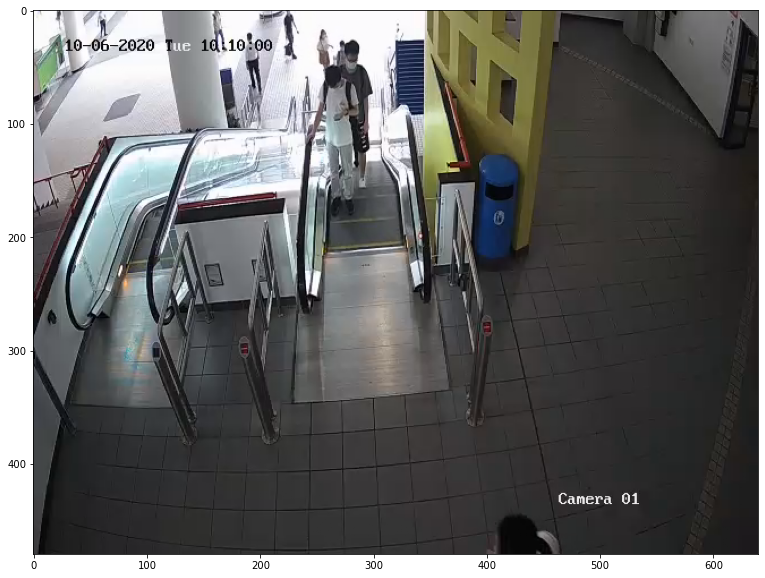

In [7]:
c35_img = cv2.imread(str(camera_35_fpaths[0]),cv2.IMREAD_COLOR)
c35_img = cv2.cvtColor(c35_img,cv2.COLOR_BGR2RGB).astype(np.float32)
_, ax = plt.subplots(1,1,figsize=(16,10))
c35_img /= 255.
#c35_img = cv2.line(c35_img,(0,160),(640,160),(0,1,0),2)
ax.imshow(c35_img)

# NOTE:

1.During detection, camera 33 and 34 has overlap regions which excluded from 33

2.Camera 34 and 35 has similar view, suggest only use one of each as result

# Camera 34 result

In [9]:
pred_files = get_files_in_dir(path/'result/34_demo_output',extensions=['png'])
pred_files = sorted(pred_files,key=lambda i: os.path.splitext(os.path.basename(i))[0])

In [10]:
def has_box(fname):
    return os.path.exists(str(fname).split('.')[0]+'.txt')

def coco2pascal(box,img_size):
    
    '''
        box is a list with coco format (xc,yc,w,h)
        img_size is a tuple with w,h
    '''
    xc,yc,w,h = box[0]*img_size[0],box[1]*img_size[1],box[2]*img_size[0],box[3]*img_size[1]
    x1 = xc-w/2
    y1 = yc-h/2
    x2 = xc+w/2
    y2 = yc+h/2
    return [x1,y1,x2,y2]

def keepbox_camera34(box,ykeep=160):
    '''
        box is a list with pascal format (xyxy)
    '''
    return box[-1] > ykeep

def keepbox_camera33(box,xkeep=480):
    return box[2] < xkeep
    

In [11]:
def process_output(fpaths,cam_pos,img_size=(640,480)):
    '''
        fpaths:    list of .png files 
                   pred_box should be in the same folder with .png files
        cam_pos:   33 or 34 for blocked out region
        img_size:  original img_size
        
        return filtered box, all box, no box detected file and count
    '''
    res, all_boxes, no_detect_files, count = [],[],[],[]
    for file in fpaths:
        if not has_box(file):
            no_detect_files.append(file)
            count.append(0)
            continue
        file = str(file).split('.')[0]+'.txt'
        with open(file,'r') as fp:
            result = []
            boxes = []
            lines = [l.rstrip() for l in fp]
            for line in lines:
                box = [float(x) for x in line.split(' ')][1:]
                box = coco2pascal(box,img_size)
                if cam_pos == 34 and keepbox_camera34(box):
                    result.append(box)
                elif cam_pos == 33 and keepbox_camera33(box):
                    result.append(box)
                elif cam_pos ==35:
                    result.append(box)
                boxes.append(box)
            count.append(len(result))
            res.append(result)
            all_boxes.append(boxes)
    return res,all_boxes,no_detect_files,count

In [12]:
res,all_boxes,no_detect_files,count = process_output(pred_files,34)

In [13]:
def show_result(fpaths,idx,all_box,res_box):
    img = cv2.imread(str(fpaths[idx]),cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB).astype(np.float32)
    _, ax = plt.subplots(1,2,figsize=(16,10))
    img /= 255.
    #cv2.line(c34_img,(0,160),(640,160),(0,1,0),2)
    for box in all_box:
        cv2.rectangle(img,(round(box[0]),round(box[1])),(round(box[2]),round(box[3])),(0,1,0),2)
    ax[0].title.set_text('without block out region')
    ax[0].imshow(img)

    img = cv2.imread(str(fpaths[idx]),cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB).astype(np.float32)
    img /= 255.
    for box in res_box:
        cv2.rectangle(img,(round(box[0]),round(box[1])),(round(box[2]),round(box[3])),(0,0,1),2)
    ax[1].title.set_text('actual box that count')
    ax[1].imshow(img)

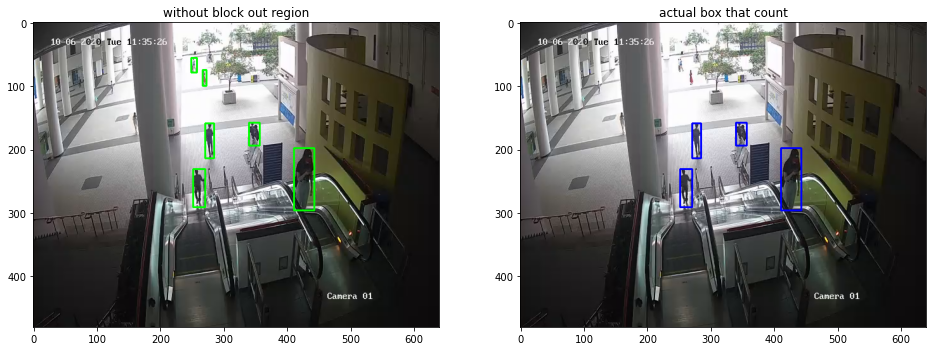

In [20]:
idx = 104
all_box = all_boxes[idx]
res_box = res[idx]
show_result(camera_34_fpaths,idx,all_box,res_box)

This is one good example, but the model still missing 1 count compare to ground truth

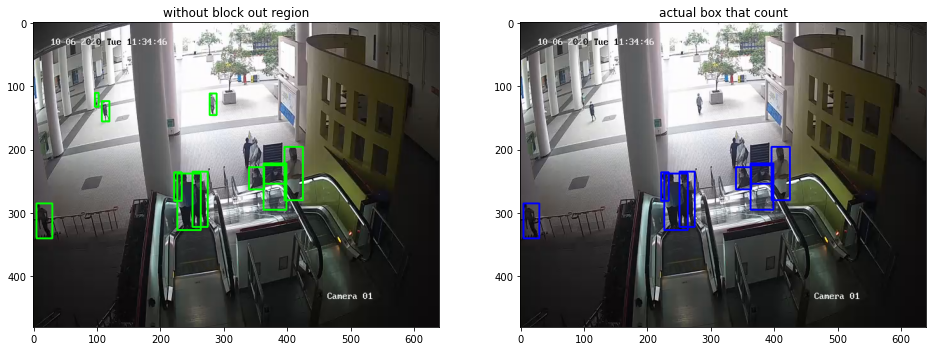

In [22]:
idx = 64
all_box = all_boxes[idx]
res_box = res[idx]
show_result(camera_34_fpaths,idx,all_box,res_box)

Another good example, but the left escalator actually has 5 person, the model only detected 3

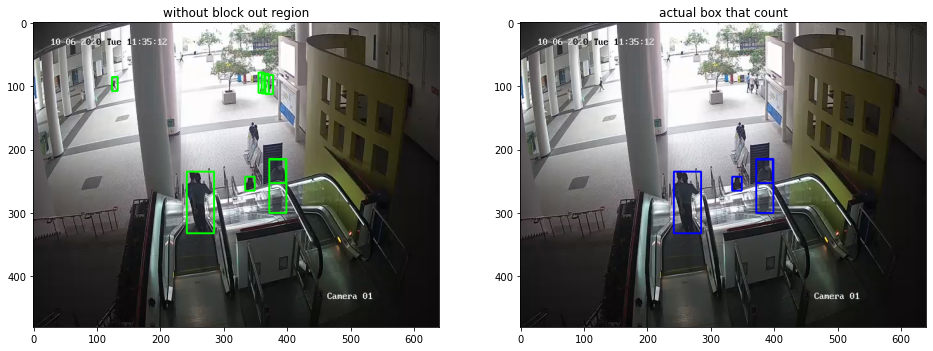

In [31]:
idx = 90
all_box = all_boxes[idx]
res_box = res[idx]
show_result(camera_34_fpaths,idx,all_box,res_box)

One bad example, the correct count should be 6, the model only detected 3

# GT manually counted for the first 120s

In [32]:
gt_count = [11,8,9,9,9,9,8,8,8,8,8,7,7,7,4,4,5,5,7,7,8,8,9,8,9,9,9,10,9,7,7,7,7,7,8,8,9,9,8,8,8,8,8,8,8,8,8,8,9,9,10,10,11,12,14,14,13,13,13,12,11,11,10,10,10,10,10,10,10,10,10,8,8,8,8,9,9,9,8,9,9,8,8,9,6,6,6,6,6,6,6,6,6,6,6,6,6,6,5,5,5,5,5,5,5,5,6,6,6,7,7,6,6,6,5,5,4,4,4,5]

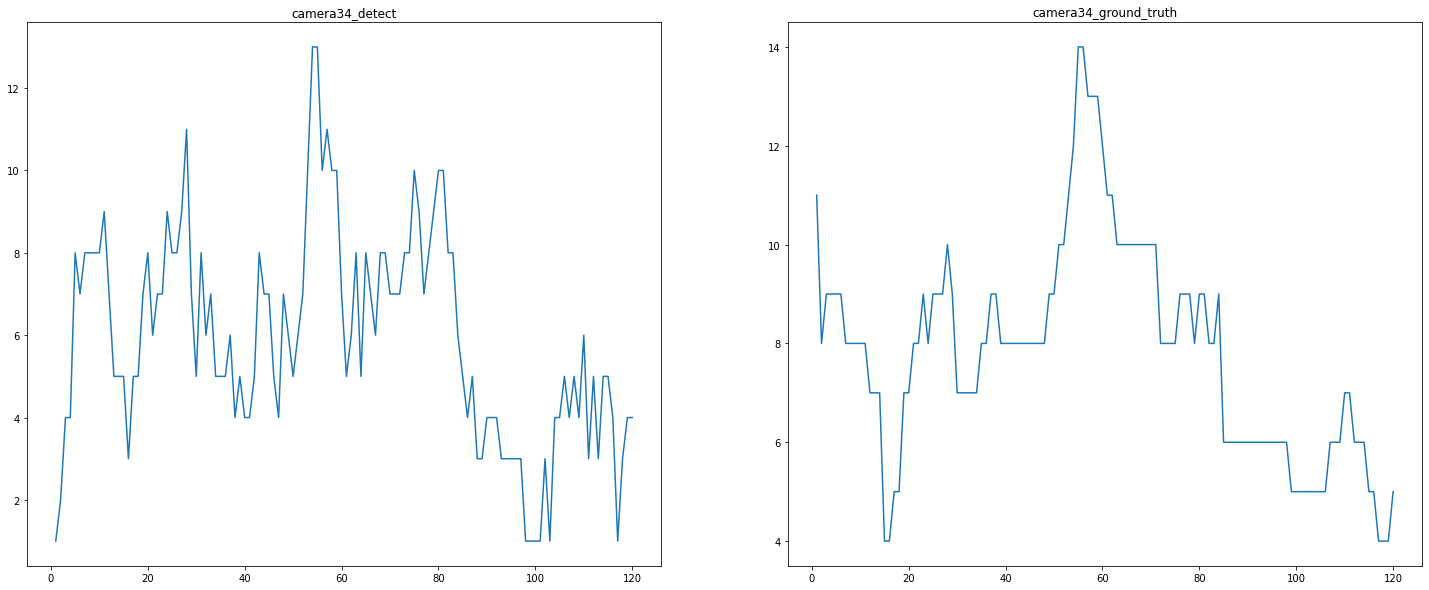

In [33]:
_,ax = plt.subplots(1,2,figsize=(25,10))
ax[0].title.set_text('camera34_detect')
ax[0].plot(np.linspace(1,120,num=120),count)
ax[1].title.set_text('camera34_ground_truth')
ax[1].plot(np.linspace(1,120,num=120),gt_count)

This is the count plot againt time (sec), on the left is the detection result, on the right is the ground truth for camera 34

# Camera 35

In [34]:
pred_files = get_files_in_dir(path/'result/35_demo_output',extensions=['png'])
pred_files = sorted(pred_files,key=lambda i: os.path.splitext(os.path.basename(i))[0])

In [35]:
res,all_boxes,no_detect_files,count = process_output(pred_files,35)

## NOTE, camera 35 has no block out, left plot should match right plot

Few result visualization

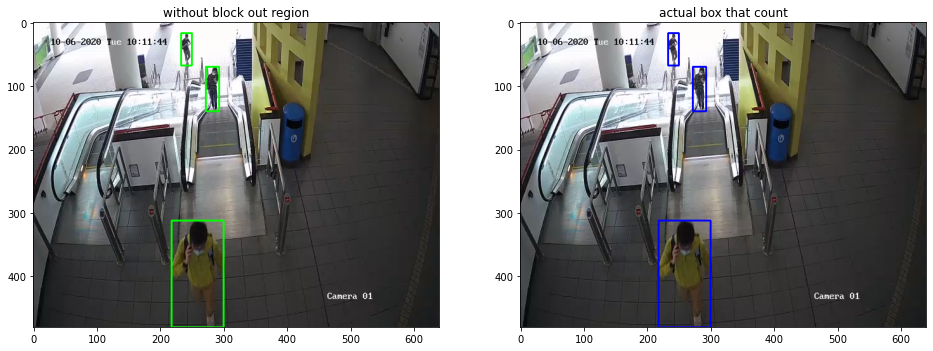

In [37]:
idx = 104
all_box = all_boxes[idx]
res_box = res[idx]
show_result(camera_35_fpaths,idx,all_box,res_box)

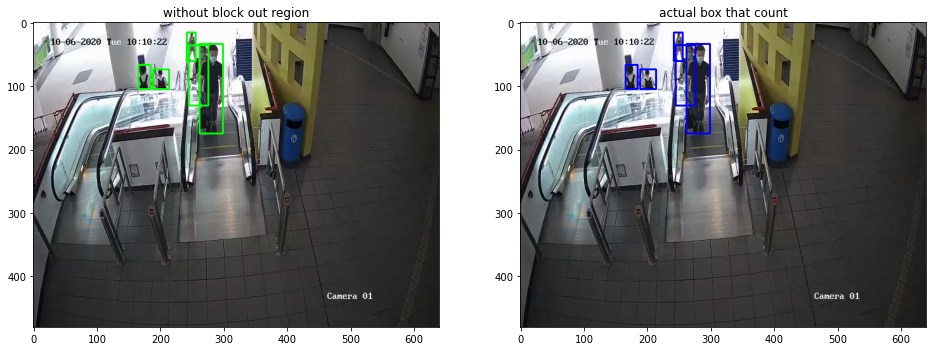

In [45]:
idx = 22
all_box = all_boxes[idx]
res_box = res[idx]
show_result(camera_35_fpaths,idx,all_box,res_box)

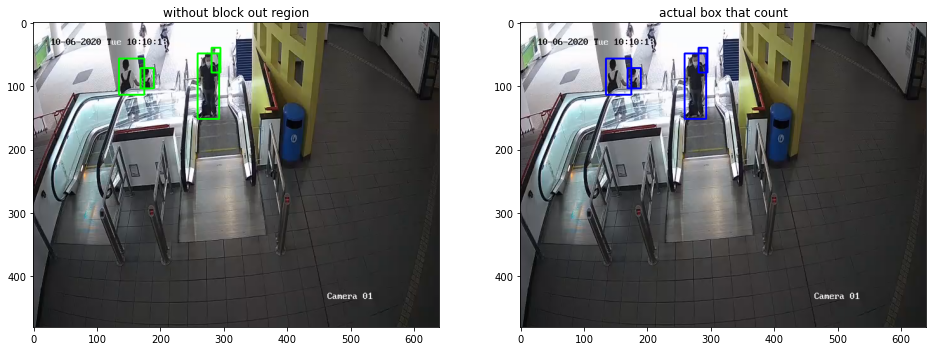

In [58]:
idx = 18
all_box = all_boxes[idx]
res_box = res[idx]
show_result(camera_35_fpaths,idx,all_box,res_box)

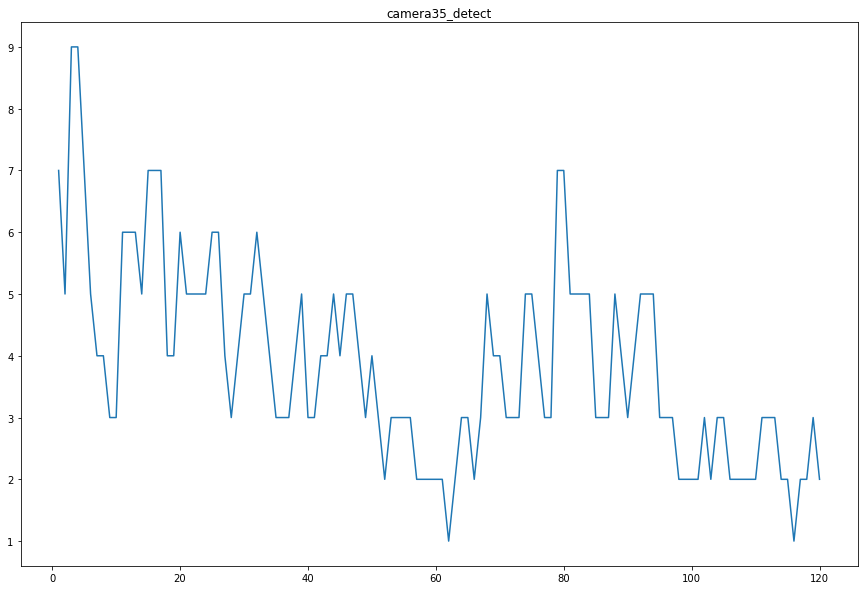

In [60]:
_,ax = plt.subplots(1,1,figsize=(15,10))
ax.title.set_text('camera35_detect')
ax.plot(np.linspace(1,120,num=120),count)

# Camera 33

In [61]:
pred_files = get_files_in_dir(path/'result/33_demo_output',extensions=['png'])
pred_files = sorted(pred_files,key=lambda i: os.path.splitext(os.path.basename(i))[0])

In [64]:
res,all_boxes,no_detect_files,count = process_output(pred_files,33)

In [69]:
no_detect_files

[PosixPath('/home/heye0507/zhangyu_project/result/33_demo_output/33_out00037.png'),
 PosixPath('/home/heye0507/zhangyu_project/result/33_demo_output/33_out00038.png'),
 PosixPath('/home/heye0507/zhangyu_project/result/33_demo_output/33_out00039.png'),
 PosixPath('/home/heye0507/zhangyu_project/result/33_demo_output/33_out00040.png'),
 PosixPath('/home/heye0507/zhangyu_project/result/33_demo_output/33_out00045.png'),
 PosixPath('/home/heye0507/zhangyu_project/result/33_demo_output/33_out00047.png'),
 PosixPath('/home/heye0507/zhangyu_project/result/33_demo_output/33_out00092.png'),
 PosixPath('/home/heye0507/zhangyu_project/result/33_demo_output/33_out00095.png'),
 PosixPath('/home/heye0507/zhangyu_project/result/33_demo_output/33_out00100.png'),
 PosixPath('/home/heye0507/zhangyu_project/result/33_demo_output/33_out00103.png')]

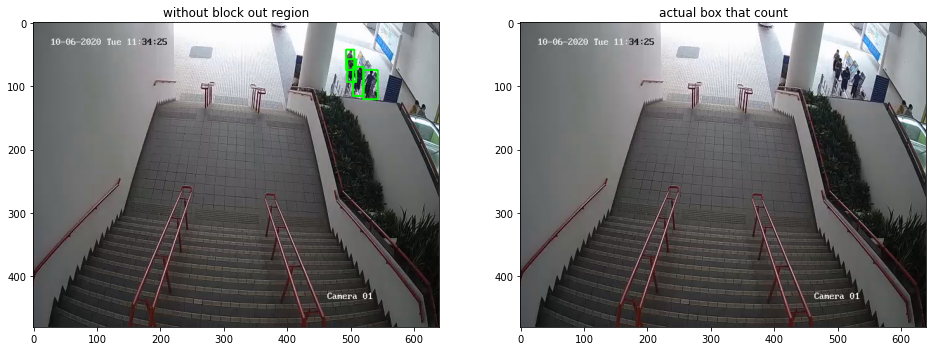

In [72]:
idx = 35
all_box = all_boxes[idx]
res_box = res[idx]
show_result(camera_33_fpaths,idx,all_box,res_box)

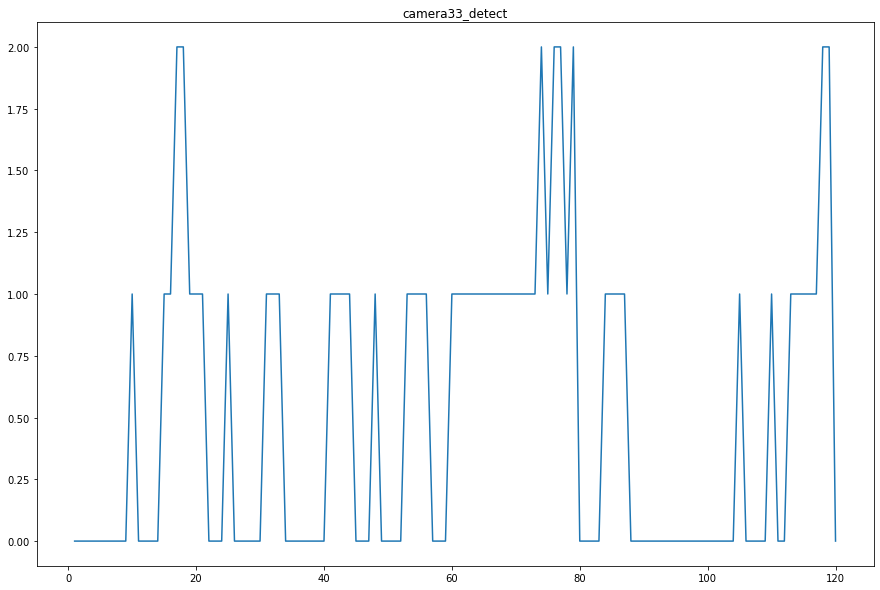

In [73]:
_,ax = plt.subplots(1,1,figsize=(15,10))
ax.title.set_text('camera33_detect')
ax.plot(np.linspace(1,120,num=120),count)

# Fin